In [1]:
# # Input data files are available in the "../input/" directory.
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('C:/Users/das_g/Desktop/Gitua/CatherineLopes/'):
#     for filename in filenames:
#         print(os.path.join(dirname,filename))

# # Any results you write to the current directory are saved as output.

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


# -------------- Confirmed cases  -----------------------------
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/\
csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df = pd.read_csv(url, index_col="Country/Region")
df.drop(['Lat', 'Long'], axis=1, inplace=True)
df.head(10)

# #df.loc["US"].sum()

Aust_tot = df.loc["Australia"].sum()
Aust_tot.drop("Province/State", inplace=True)

China_Hubei = df.loc[df["Province/State"] == "Hubei"].sum()
China_Hubei.drop("Province/State", inplace=True)

China_Rest = df.loc["China"].sum() - China_Hubei
China_Rest.drop("Province/State", inplace=True)

pos= (df.index == "Australia")
x = df.at["Australia", "Province/State"]
counter = 0
for i in range(len(pos)):  
   if pos[i] == True:
      df.index.values[i]= "Australia_"+ x[counter]
      counter +=1
del df["Province/State"]        
df.head(10)

Aust_tot = df[df.index.str.startswith("Australia_")].sum()
new_row = pd.Series(data=Aust_tot, name = "Australia_total")
df = df.append(new_row, ignore_index=False)
new_row = pd.Series(data=China_Hubei, name = "China_Hubei")
df = df.append(new_row, ignore_index=False)
new_row = pd.Series(data=China_Rest, name = "China_Rest")
df = df.append(new_row, ignore_index=False)

gr_df = df.groupby("Country/Region").sum()
gr_df.loc["US"]

#Dates are converted into no of days since 1/22/20 (22Jan2010) so 1/22/20 corresponds to day 1
dates = gr_df.keys()
# # dates = dates[1::]
FMT = '%m/%d/%y'
days = dates.map(lambda x: (datetime.strptime(x, FMT) - datetime.strptime("1/22/20", FMT)).days) 
gr_df.columns = days
x1 = gr_df.ne(0).idxmax(axis=1) # x1 gives position of first non-zero value in each row

for i in range(gr_df.shape[0]):
    gr_df.iloc[i] = gr_df.iloc[i].shift(periods=-x1[i]) # data starts from day when a first case is reported

gr_df.drop(index = "China", inplace=True)
#gr_df.columns = dates

# Writing the dataframe into a csv file
gr_df.to_csv("C:/Users/das_g/Desktop/Gitua/CatherineLopes/time_series_2019-ncov-Confirmed_mod.csv")

# # Visualising time series data

import matplotlib.pyplot as plt 
# import seaborn as sns 

# #sns.set(rc={'figure.figsize':(11,4)}) # set() sets the style
plt.figure(figsize=(10,12))

plt.title("Confirmed cases (cummulative)- Australia & World")
plt.xlabel("No of Days since 1st case reported")
plt.ylabel("No of confirmed cases")

y = [gr_df.loc["Italy"], gr_df.loc["Spain"], gr_df.loc["US"], gr_df.loc["Australia_total"], gr_df.loc["Singapore"],\
    gr_df.loc["Japan"], gr_df.loc["China_Hubei"], gr_df.loc["China_Rest"], gr_df.loc["Iran"]]
labels = ["Italy", "Spain", "US", "Australia", "Singapore", "Japan", "China_Hubei", "China_Rest", "Iran"]

for y, label in zip(y, labels):
   plt.plot(days, y, label=label)

plt.legend(loc="upper left")
plt.yscale("log")
plt.grid(which="both")
#plt.ylim(10**1,10**7)
#plt.plot(days, y1, '--bo', label="Italy")

plt.savefig('C:/Users/das_g/Desktop/Plot_Aust.jpg')
plt.show()


<Figure size 1000x1200 with 1 Axes>

In [3]:
# Using K-means clustering to find the number of clusters in our dataset. In our case gr_df.shape[0] is the no of samples
# and gr_df.shape[1] (i.e days) is the no of features


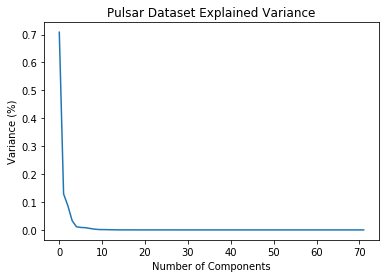

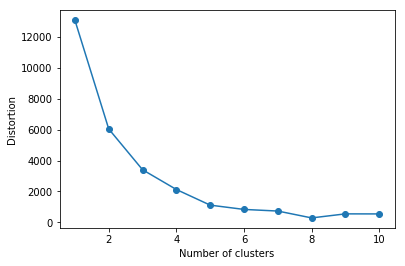

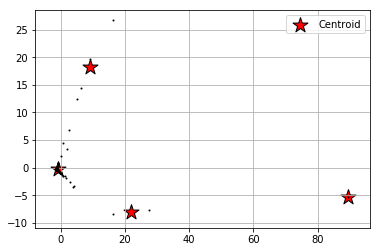

In [4]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

data_rescaled = scale(gr_df.fillna(0), axis=0) # scale all data with centre to mean and unit variance
pca = PCA().fit(data_rescaled)

#Plotting the Cumulative Summation of the Explained Variance. This helps to choose the no of components to be 
# used in PCA that provides high variance in data
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

# As per above analysis no of principal components is 3 
reduced_data = PCA(n_components=4).fit_transform(data_rescaled)

# Using Elbow method we can estimate the optimal number of clusters. If k increases the within-cluster SSE("distortion") 
# decreases as the distance of samples from the centroid in a cluster will be less. So, look for the k-value where the 
# distortion falls sharply. As seen in the below graph the elbow point is at k=3  
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(reduced_data)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

# K-means clustering with the no of clusters as obtained from above Elbow method
km = KMeans(n_clusters=4, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(reduced_data) # cluster labels of all data points (here countries)

plt.plot(reduced_data[:,0], reduced_data[:,1], "k.", markersize=2)

plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], s=250, c='red', marker='*', edgecolor='black', label='Centroid')
plt.legend(scatterpoints=1)
plt.grid()
plt.show()


In [5]:
unique_index = pd.Index(gr_df.index)
cluster_Aust = unique_index.get_loc("Australia_total") # gives row number of Australia_total
j = 0
for j in range(4):
   print("\nCluster-", j, ": ", end=" ")
   for i in range(len(unique_index)):
      if y_km[i] == j:
         print(unique_index[i], end= " ")


Cluster- 0 :  Germany Italy Spain US 
Cluster- 1 :  China_Hubei 
Cluster- 2 :  Afghanistan Albania Algeria Andorra Angola Antigua and Barbuda Argentina Armenia Australia_Australian Capital Territory Australia_New South Wales Australia_Northern Territory Australia_Queensland Australia_South Australia Australia_Tasmania Australia_Victoria Australia_Western Australia Australia_total Austria Azerbaijan Bahamas Bahrain Bangladesh Barbados Belarus Belgium Belize Benin Bhutan Bolivia Bosnia and Herzegovina Botswana Brazil Brunei Bulgaria Burkina Faso Burma Burundi Cabo Verde Cambodia Cameroon Canada Central African Republic Chad Chile Colombia Congo (Brazzaville) Congo (Kinshasa) Costa Rica Cote d'Ivoire Croatia Cuba Cyprus Czechia Denmark Diamond Princess Djibouti Dominica Dominican Republic Ecuador Egypt El Salvador Equatorial Guinea Eritrea Estonia Eswatini Ethiopia Fiji Finland France Gabon Gambia Georgia Ghana Greece Grenada Guatemala Guinea Guinea-Bissau Guyana Haiti Holy See Honduras 